# Part 3 NSGA II

> Code is inspired from:
> 
> https://medium.com/@rossleecooloh/optimization-algorithm-nsga-ii-and-python-package-deap-fca0be6b2ffc
>
> https://github.com/DEAP/deap/blob/master/examples/ga/nsga2.py
>
>  https://github.com/DEAP/deap/blob/master/deap/tools/emo.py

In [160]:
from matplotlib import pyplot
import pandas as pd
import numpy as np
from copy import deepcopy

# Import deque for the stack structure, copy for deep copy nodes
from collections import deque
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
from sklearn.tree import DecisionTreeClassifier
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools

In [161]:

# define some constants for the genetic algorithm

CONSTANTS_DICT = {
    "POPULATION_SIZE": 80, # number of individuals in each population
    "MAX_GENERATIONS": 66, # number of generations to run the algorithm
    "CROSSOVER_RATE": 0.9, # crossover rate should be very high, based on slides
    "MUTATION_RATE": 0.2, # mutation rate
    "CLASSIFIER":KNeighborsClassifier() , # classifier to use
    # "BOUND_LOW": 0.0, # lower bound for the features
    # "BOUND_UP": 1.0, # upper bound for the features
    # "ETA": 20.0, # crowding degree for mutation  and crossover
}


# dataset load

In [162]:
from queue import Empty


class DatasetPart3:
    def __init__(self, df) :
        self.df=df
        # self.df.columns = self.df.columns.str.strip()
        self.X = self.df.iloc[:,:-1]
        self.y = self.df.iloc[:,-1]
        # self.M = self.df.shape[0]  # number of rows
    
    # @classmethod
    # def constructFromFile(cls, filePath):
    #     """Depends on different ds"""
    #     pass

    def getDfWithSelectedFeatures(self, selectedFeatures):
        """No need to avoid FS bias, just based on df"""
        
        assert len(selectedFeatures) == self.X.shape[1]
        
        # according to the selected features, get the df with selected features
        colone_X = deepcopy(self.X)
        count, index_to_drop = 0, []
        for i in range(len(selectedFeatures)):
            isSelected = selectedFeatures[i] > 0.5 
            if  isSelected:
                index_to_drop.append(i)
                count += 1
        colone_X.drop(colone_X.columns[index_to_drop], axis=1, inplace=True)
        # count = len(selectedFeatures) - sum(selectedFeatures)
        # print(count )
        assert count ==  sum(selectedFeatures), f" {count} count != { sum(selectedFeatures)}"
        # assert count != 0, f"count is {count}"
        # assert count is 
        # concat the X and y
        returnedDf = colone_X.join(self.y)
        return returnedDf, count
            
        
        
        # NOTE: the same tihng as the above, can do either way 
        
        # returnedDf = pd.DataFrame()
        # selectedCount = 0
        # for i in range(len(selectedFeatures)):
        #     isSelected = True if selectedFeatures[i] > 0.5 else False
        #     if isSelected:
        #         selectedCount += 1
        #         # concat this feature to the returned dataframe
        #         returnedDf = pd.concat([returnedDf,self.df.iloc[:,i]],axis=1)
        # # concat the class column
        # returnedDf = pd.concat([returnedDf, self.y],axis=1)
        # assert returnedDf.empty == False

        # return returnedDf, selectedCount
    
    @staticmethod
    def run_model(df:pd.DataFrame, classifier=CONSTANTS_DICT["CLASSIFIER"]):

        assert df.empty == False
        X = df.iloc[:,:-1]
        y = df.iloc[:,-1]
        
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=666)
        # classifier.fit(X_train, y_train)
        # return classifier.score(X_test, y_test)
    
        # cares ONLY about the training accuracy, so no need to split the data
        classifier.fit(X, y)
        return classifier.score(X, y)

        # # cv is super slow, so I use the train_test_split

        # # # evaluate the model
        # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=666)
        # # return the error
        # n_scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        # return np.mean(n_scores)
        
        

class Vehicle(DatasetPart3):
    def __init__(self, df):
        super().__init__(df)
    
    @classmethod
    def constructFromFile(cls, filePath):
        df = pd.read_csv(filePath, header=None, delim_whitespace=True)
        df.columns = [f"f_{i}" for i in range(len(df.columns))]
        df.rename(columns = {f'f_{len(df.columns)-1}':'class'}, inplace = True)
        return cls(df)
    
class MuskClean(DatasetPart3):
    def __init__(self, df):
        super().__init__(df)

    @classmethod
    def constructFromFile(cls, filePath):
        df = pd.read_csv(filePath, header=None)
        # ignore the first 2 columns since they are NOT numerical, so it would be betteer to ignore them 
        df.drop([0,1], axis=1, inplace=True)
        df.columns = [f"f_{i}" for i in range(len(df.columns))]
        df.rename(columns = {f'f_{len(df.columns)-1}':'class'}, inplace = True)
        return cls(df)
    


In [163]:
ds_vehicle = Vehicle.constructFromFile("./vehicle/vehicle.dat")
print(ds_vehicle.X.shape[1])
# ds_vehicle.df.info()
ds_vehicle.df

18


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,93,39,87,183,64,8,169,40,20,134,200,422,149,72,7,25,188,195,saab
842,89,46,84,163,66,11,159,43,20,159,173,368,176,72,1,20,186,197,van
843,106,54,101,222,67,12,222,30,25,173,228,721,200,70,3,4,187,201,saab
844,86,36,78,146,58,7,135,50,18,124,155,270,148,66,0,25,190,195,saab


In [164]:
# ds_mushclean = MuskClean.constructFromFile("./musk/clean1.data")
# ds_mushclean.df
# # # len(ds_mushclean.x.columns)

# set up creator

In [165]:
# 2 minimum objectives, so -1,-1
creator.create("MultiObjMin", base.Fitness, weights=(-1.0, -1.0)) 
# Individual should be a list of binary values, i.e. a list of 0s and 1s
creator.create("Individual", list, fitness=creator.MultiObjMin)

/usr/pkg/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'MultiObjMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/pkg/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


define wrapper based fitness evaluate function

In [166]:
def wrapperFitnessEvaluation(ds:DatasetPart3, individual:creator.Individual, 
                             classifier=CONSTANTS_DICT["CLASSIFIER"]): #KNN by default
    df_selected,selected_count = ds.getDfWithSelectedFeatures(individual)
    # df_selected = getTransformedDf(df_selected)
    
    if selected_count == 0:
        return 99999, 99999 # return a very large number to penalty no feature selected
    
    
    
    acc_score = DatasetPart3.run_model(df_selected, classifier)
    obj1 = 1.0-acc_score # classification error
    obj2 = selected_count / len(individual) #ratio of selected features
    assert 0<=obj1<=1 and 0<=obj2<=1
    return obj1, obj2

tool box

> https://www.researchgate.net/publication/235707001_DEAP_Evolutionary_algorithms_made_easy

In [167]:
# from deap import dtm
# toolbox is a class contains the operators that we will use in our genetic programming algorithm
# it can be also be used as the container of methods which enables us to add new methods to the toolbox 
def setup_toolbox(ds:DatasetPart3, randSeed:int) -> base.Toolbox:
    toolbox = base.Toolbox()
    # toolbox.register("map",dtm.map)
    
    # for population size, we use the random.randint function to generate a random integer in the range [min, max]
    random.seed(randSeed)
    # register a method to generate random boolean values
    toolbox.register("attr_bool", random.randint, 0, 1)
    # register a method to generate random individuals
    toolbox.register("IndividualCreator", 
                     tools.initRepeat, 
                     creator.Individual, 
                     toolbox.attr_bool, 
                     n=len(ds.X.columns) # feature number, exclude the class column
                    )
    
    # N is not specificied, so need to specify number of individuals to generate within each population when we call it later
    toolbox.register("PopulationCreator", tools.initRepeat, list, toolbox.IndividualCreator) 

    # toolbox.register("select", tools.emo.selTournamentDCD)
    toolbox.register("select", tools.selNSGA2)
    toolbox.register('selectGen1', tools.selTournament, tournsize=2)
    
    
    
    # toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=CONSTANTS_DICT["BOUND_LOW"], up=CONSTANTS_DICT["BOUND_UP"], eta=CONSTANTS_DICT["ETA"])
    # toolbox.register("mutate", tools.mutPolynomialBounded, low=CONSTANTS_DICT["BOUND_LOW"], up=CONSTANTS_DICT["BOUND_UP"], eta=CONSTANTS_DICT["ETA"], indpb=1.0/len(ds.x.columns))
    

    
    toolbox.register("mate", tools.cxTwoPoint)
    # indpb refer to the probability of mutate happening on each gene, it is NOT the same as mutation rate
    toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/len(ds.X.columns)) 
    
    toolbox.register("evaluate", wrapperFitnessEvaluation, ds) # need to pass individual:list
    return toolbox

# run NSGA once  asas

> https://github.dev/DEAP/deap/blob/master/deap/tools/emo.py
> https://github.dev/DEAP/deap/blob/master/examples/ga/nsga2.py

In [168]:
import copy
from select import select
import time

def run_NSGAII(ds:DatasetPart3, randSeed:int, 
                ngen:int=CONSTANTS_DICT["MAX_GENERATIONS"], 
                popSize:int=CONSTANTS_DICT["POPULATION_SIZE"]):
    # stats
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)
    stats.register("mean", np.mean, axis = 0)
    stats.register("std", np.std, axis=0)
    # for record keeping
    logbook = tools.Logbook()    
    logbook.header = "gen", "mean", "std", "min", "max"
    
    # create toolbox
    random.seed(randSeed)
    toolbox = setup_toolbox(ds, randSeed)
    
    # calculate objectives
    def evaluate_update_fitness_values(p) :
        """Update the fitness values of each individual for the given the population"""
        fitnesses = list(map(toolbox.evaluate, p))
        for ind, fit in zip(p, fitnesses):
            ind.fitness.values = fit

             
     # initial population 
    pop = toolbox.PopulationCreator(n=popSize)
    evaluate_update_fitness_values(pop)
    
    
    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, **record)
    print(logbook.stream)
    
    # # fast non dominated sort
    # fronts = tools.emo.sortNondominated(pop,k=popSize)
    # for idx,front in enumerate(fronts):
    #     #print(idx,front)
    #     for ind in front:
    #         ind.fitness.values = (idx+1),# change fitness to the order of pareto front
    
    # #  generate offspring
    # offspring = toolbox.selectGen1(pop, len(pop))
    # # apply mate and mutate only once
    # offspring = algorithms.varAnd(offspring,toolbox,
    #                               CONSTANTS_DICT["CROSSOVER_RATE"],
    #                               CONSTANTS_DICT["MUTATION_RATE"]) 

    # Begin the generational process
    for gen_counter in range(1,ngen):
        
        # Vary the pop
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        # apply mate and mutate , clone the individual, 
        # so returned offspring is independent of input parents
        offspring = algorithms.varAnd(offspring, toolbox, 
                                      cxpb=CONSTANTS_DICT["CROSSOVER_RATE"], 
                                      mutpb=CONSTANTS_DICT["MUTATION_RATE"])
           
        # Evaluate all  offsprings individuals 
        combined_pop = offspring + pop
        evaluate_update_fitness_values(combined_pop)
      
        # elitism strategy
        # Select the next generation pop
        pop = toolbox.select(combined_pop, popSize)
        # stats
        record = stats.compile(pop)
        logbook.record(gen=gen_counter,  **record)
        print(logbook.stream)
        
    print("Final pop hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))
    return pop, logbook, hypervolume(pop, [11.0, 11.0]) # pop is a set of non-dominated individuals solutions

    # # create the initial population
    # pop = toolbox.PopulationCreator(n=popSize)
    # evaluate_update_fitness_values(pop)
    # for g in range(ngen):
    #     offspring = algorithms.varAnd(pop, toolbox, 
    #                                   cxpb=CONSTANTS_DICT["CROSSOVER_RATE"], 
    #                                   mutpb=CONSTANTS_DICT["MUTATION_RATE"])
    #     evaluate_update_fitness_values(offspring)
    #     pop = toolbox.select(pop + offspring, k=len(pop))
    #     record = stats.compile(pop)
    #     logbook.record(gen=g,  **record)
    #     print(logbook.stream)
    

   

Another NSGA 2 implementation from 

> https://blog.csdn.net/weixin_46649052/article/details/110230757

In [169]:
import copy
from select import select
import time


def run_NSGAII_2(ds:DatasetPart3, randSeed:int, 
                ngen:int=CONSTANTS_DICT["MAX_GENERATIONS"], 
                popSize:int=CONSTANTS_DICT["POPULATION_SIZE"]):
    # stats
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)
    stats.register("mean", np.mean, axis = 0)
    stats.register("std", np.std, axis=0)
    # for record keeping
    logbook = tools.Logbook()    
    logbook.header = "gen", "mean", "std", "min", "max"
    
    # create toolbox
    random.seed(randSeed)
    toolbox = setup_toolbox(ds, randSeed)
    
    # calculate objectives
    def evaluate_update_fitness_values(p) :
        """Update the fitness values of each individual for the given the population"""
        fitnesses = list(map(toolbox.evaluate, p))
        for ind, fit in zip(p, fitnesses):
            ind.fitness.values = fit
             
     # initial population 
    pop = toolbox.PopulationCreator(n=popSize)
    evaluate_update_fitness_values(pop)
    record = stats.compile(pop)
    logbook.record(gen=0, **record)
    print(logbook.stream)
    
    # fast non dominated sort
    fronts = tools.emo.sortNondominated(pop,k=popSize)
    for idx,front in enumerate(fronts):
        #print(idx,front)
        for ind in front:
            ind.fitness.values = (idx+1),# change fitness to the order of pareto front
    
    #  generate offspring
    offspring = toolbox.selectGen1(pop, len(pop))
    # apply mate and mutate only once
    offspring = algorithms.varAnd(offspring,toolbox,
                                  CONSTANTS_DICT["CROSSOVER_RATE"],
                                  CONSTANTS_DICT["MUTATION_RATE"]) 

    # Begin the generational process
    for gen_counter in range(1,ngen):
        # Evaluate all  offsprings individuals 
        combined_pop = offspring + pop
        evaluate_update_fitness_values(combined_pop)
        
        # fast non dominated sort
        fronts =  tools.emo.sortNondominated(combined_pop,k=popSize,first_front_only=False)
        
        # crowding distance
        for front in fronts:
            tools.emo.assignCrowdingDist(front)
            
        # environmental selection -- elitism strategy
        pop = []
        for front in fronts:
            pop +=front
            
        # use the select function that based on crowding distance to implement elitism strategy
        pop = tools.selNSGA2(toolbox.clone(pop), popSize)
        
        # generate offspring
        offspring = tools.selTournamentDCD(pop, popSize)
        offspring = toolbox.clone(offspring)
        offspring = algorithms.varAnd(offspring, toolbox,
                                      cxpb=CONSTANTS_DICT["CROSSOVER_RATE"],
                                      mutpb=CONSTANTS_DICT["MUTATION_RATE"])
        
        # stats
        record = stats.compile(pop)
        logbook.record(gen = gen_counter,**record)
        print(logbook.stream)
        
        
    print("Final pop hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))
    return pop, logbook, hypervolume(pop, [11.0, 11.0]) # pop is a set of non-dominated individuals solutions



   

# run 3 times

In [170]:
import matplotlib.pyplot as plt
def run_3_times_with_different_seed(ds:DatasetPart3,
                                     title:str, 
                                     max_gen=CONSTANTS_DICT["MAX_GENERATIONS"],
                                     classifier = CONSTANTS_DICT["CLASSIFIER"],
                                     randSeed = [i+1 for i in range(3)],
                                     run_times=3):
    # run 3 times with different seed
    population_list = []
    logbook_list = []
    hypervolume_list = []
    
    color_list = ['r.','g.','b.','c.','m.','y.','k.']
    front_list = []
    for i in range(run_times):
        print('-'*80)
        print('-'*80)
        print(title,"\nRunning GA with seed: ", randSeed[i])
        population, logbook, hypervolume = run_NSGAII(ds, randSeed=randSeed[i], ngen=max_gen, popSize=CONSTANTS_DICT["POPULATION_SIZE"])
        population_list.append(population)
        logbook_list.append(logbook)
        hypervolume_list.append(hypervolume)    
        print('-'*80)
        print('-'*80)
        
        # # plot the result
        front = tools.emo.sortNondominated(population,len(population),first_front_only=True)[0]
        err_rate = [ind.fitness.values[0] for ind in front]
        ratio_selcted = [ind.fitness.values[1] for ind in front]
        # for ind in front:
        plt.plot(err_rate, ratio_selcted, color_list[i] , ms=2,
                 label = f"seed {randSeed[i]},hypervolume: {hypervolume}")
        plt.ylabel("ratio of selected features")
        plt.xlabel("classification error rate")
        plt.title(f"dataset: {title}, seed: {randSeed[i]}\nhypervolume: {hypervolume}\n Objective space")
        # plt.tight_layout()
    # plt.legend(bbox_to_anchor =(1.3,-0.1), loc='lower center')
        plt.show()
        print(len(front))
        
        # append front to front_list, remove duplicates
        front = [ind.fitness.values for ind in front]
        front = list(set(front))
        front_list.append(front)
        print(len(front))
        
      
    # compare error rates of the obtained solutions with that of using the entire feature set.
    subset_mean_err_rate = [logbook.select("min")[-1][0] for logbook in logbook_list]
    entire_mean_err_rate = 1-DatasetPart3.run_model(ds.df)
    
    print(f"{title}:\n error rate of using the entire feature set: {entire_mean_err_rate}")
        
    print(f"hypervolume of the obtained solution for each run : {hypervolume_list}")

    return population_list, logbook_list, hypervolume_list, front_list

In [171]:
def print_pareto_optimal_solutions_details(front_list:list):
  print(f"Pareto-optimal solutions : ")
  # remove duplicates
  # front_list = [list(t) for t in set(tuple(element) for element in front_list)]
  
  for i in range(len(front_list)) :
      front = front_list[i]
      
      print("-"*60)
      print(f"|Pareto-optimal front individuals for run with seed {i+1}:| error rate| ratio of selected features |")
      for j in range(len(front)):
          ind = front[j]
          print(f"|Individual: {j} | {ind[0]} | {ind[1]}|")
          # print(f"|Individual: {j} | {ind.fitness.values[0]} | {ind.fitness.values[1]}|")
                                  
  print("-"*80)
  

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vehicle 
Running GA with seed:  1
gen	mean                   	std                    	min                    	max                    
0  	[0.23435284 0.50763889]	[0.02882364 0.11410675]	[0.17730496 0.22222222]	[0.31914894 0.72222222]
1  	[0.21035757 0.42083333]	[0.01665099 0.10197699]	[0.17730496 0.22222222]	[0.26595745 0.66666667]
2  	[0.19976359 0.38611111]	[0.01198176 0.10500588]	[0.1749409  0.16666667]	[0.23286052 0.55555556]
3  	[0.19429669 0.35208333]	[0.01174827 0.10792078]	[0.16903073 0.16666667]	[0.23522459 0.55555556]
4  	[0.19157801 0.32152778]	[0.01274703 0.10960569]	[0.16903073 0.05555556]	[0.23522459 0.55555556]
5  	[0.18869681 0.29791667]	[0.01298253 0.11188748]	[0.16903073 0.05555556]	[0.22458629 0.5       ]
6  	[0.18356974 0.30138889]	[0.01081318 0.11579536]	[0.1678487  0.05555556]	[0.21276596 0.5       ]
7  	

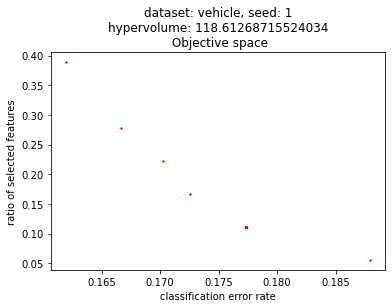

80
6
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vehicle 
Running GA with seed:  2
gen	mean                   	std                    	min                    	max                    
0  	[0.2296247  0.48194444]	[0.02868029 0.14130537]	[0.1820331  0.11111111]	[0.32742317 0.83333333]
1  	[0.20820035 0.3625    ]	[0.01238281 0.11418491]	[0.1820331  0.05555556]	[0.23877069 0.66666667]
2  	[0.20231974 0.29166667]	[0.01392398 0.10374916]	[0.1713948  0.05555556]	[0.23877069 0.61111111]
3  	[0.19595154 0.26666667]	[0.0127979  0.11159616]	[0.17021277 0.05555556]	[0.22813239 0.61111111]
4  	[0.19434102 0.22638889]	[0.01456552 0.11275691]	[0.1678487  0.05555556]	[0.21749409 0.44444444]
5  	[0.18758865 0.22986111]	[0.01533047 0.11971666]	[0.1607565  0.05555556]	[0.21158392 0.44444444]
6  	[0.18463357 0.21319444]	[0.01600269 0.12153968]	[0.1607565  0.05555556]	[0.21749409 0.44444444]

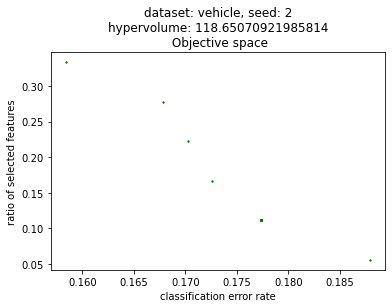

80
6
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vehicle 
Running GA with seed:  3
gen	mean                   	std                    	min                    	max                    
0  	[0.23489953 0.51180556]	[0.03141017 0.12381966]	[0.18085106 0.27777778]	[0.32742317 0.77777778]
1  	[0.20814125 0.43055556]	[0.01623542 0.11963809]	[0.17966903 0.22222222]	[0.25413712 0.66666667]
2  	[0.19502069 0.39305556]	[0.00839471 0.12903219]	[0.1749409  0.16666667]	[0.21631206 0.66666667]
3  	[0.18961288 0.34513889]	[0.00977895 0.13312882]	[0.1607565  0.11111111]	[0.21158392 0.61111111]
4  	[0.18522459 0.32638889]	[0.00975697 0.13982325]	[0.1607565  0.11111111]	[0.21040189 0.55555556]
5  	[0.18055556 0.33125   ]	[0.00941276 0.15301591]	[0.1607565  0.11111111]	[0.20803783 0.55555556]
6  	[0.1778221 0.30625  ]  	[0.01107245 0.16268241]	[0.1607565  0.05555556]	[0.20803783 0.55555556]

In [172]:
ds_vehicle = Vehicle.constructFromFile("./vehicle/vehicle.dat")
pop_list_vehicle,logbook_list_vehicle, hypervolume_list_vehicle, front_list_vehicle = run_3_times_with_different_seed(ds_vehicle, "vehicle",
                                max_gen=66,
                                run_times=3)

print_pareto_optimal_solutions_details(front_list_vehicle)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
muskclean 
Running GA with seed:  1
gen	mean                   	std                    	min                    	max                    
0  	[0.07704832 0.49518072]	[0.01195254 0.03682098]	[0.05042017 0.42168675]	[0.11344538 0.62650602]
1  	[0.06964286 0.4685241 ]	[0.01047843 0.02576974]	[0.04201681 0.42168675]	[0.10504202 0.54819277]
2  	[0.06615021 0.45670181]	[0.01056178 0.02928191]	[0.04201681 0.39759036]	[0.09243697 0.54819277]
3  	[0.06179097 0.44631024]	[0.00864729 0.03499935]	[0.03571429 0.39156627]	[0.09033613 0.54819277]
4  	[0.05871849 0.43960843]	[0.00927052 0.04225438]	[0.03571429 0.36144578]	[0.07983193 0.54819277]
5  	[0.05548845 0.43674699]	[0.00994684 0.05310951]	[0.03571429 0.35542169]	[0.07983193 0.56024096]
6  	[0.05128676 0.43840361]	[0.00988564 0.06057868]	[0.03571429 0.35542169]	[0.07983193 0.56024096]
7 

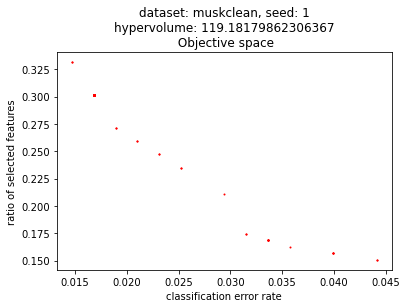

80
12
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
muskclean 
Running GA with seed:  2
gen	mean                   	std                    	min                    	max                    
0  	[0.07935924 0.50361446]	[0.01017323 0.03608932]	[0.05882353 0.39759036]	[0.1092437  0.58433735]
1  	[0.07250525 0.47816265]	[0.0083109  0.03578353]	[0.05672269 0.39759036]	[0.08823529 0.56626506]
2  	[0.0696166  0.45783133]	[0.00882443 0.03266371]	[0.05462185 0.37951807]	[0.08613445 0.54819277]
3  	[0.06738445 0.44111446]	[0.01030148 0.03340489]	[0.04411765 0.37951807]	[0.08823529 0.54819277]
4  	[0.06347164 0.43584337]	[0.0107055  0.04020943]	[0.04411765 0.35542169]	[0.08823529 0.54819277]
5  	[0.06066176 0.43177711]	[0.0112908  0.04382271]	[0.04411765 0.35542169]	[0.08823529 0.54819277]
6  	[0.06116071 0.41039157]	[0.01193045 0.04562408]	[0.03781513 0.3253012 ]	[0.08823529 0.548192

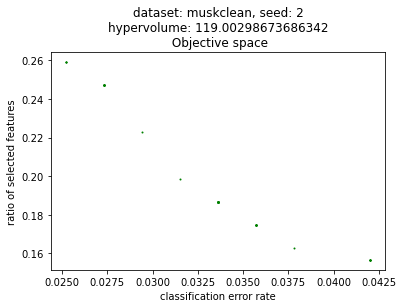

43
8
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
muskclean 
Running GA with seed:  3
gen	mean                   	std                    	min                    	max                    
0  	[0.07773109 0.50948795]	[0.0104621  0.03433966]	[0.05252101 0.42771084]	[0.10084034 0.57831325]
1  	[0.07008929 0.48283133]	[0.00950177 0.03225987]	[0.05042017 0.40361446]	[0.09243697 0.57831325]
2  	[0.06583508 0.4684488 ]	[0.01009685 0.0369666 ]	[0.05042017 0.40361446]	[0.09663866 0.57831325]
3  	[0.06320903 0.45911145]	[0.00919459 0.03969388]	[0.05042017 0.37951807]	[0.09663866 0.57228916]
4  	[0.06165966 0.44246988]	[0.01006487 0.03841867]	[0.03781513 0.37951807]	[0.08823529 0.55421687]
5  	[0.05963761 0.43162651]	[0.01098929 0.04448358]	[0.03781513 0.3313253 ]	[0.08823529 0.55421687]
6  	[0.05722164 0.41521084]	[0.01127549 0.04161398]	[0.03361345 0.3313253 ]	[0.08193277 0.5542168

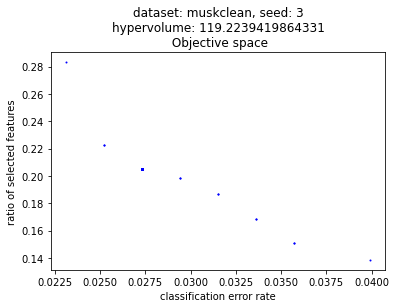

80
8
muskclean:
 error rate of using the entire feature set: 0.06302521008403361
hypervolume of the obtained solution for each run : [119.18179862306367, 119.00298673686342, 119.2239419864331]
Pareto-optimal solutions : 
------------------------------------------------------------
|Pareto-optimal front individuals for run with seed 1:| error rate| ratio of selected features |
|Individual: 0 | 0.018907563025210128 | 0.2710843373493976|
|Individual: 1 | 0.031512605042016806 | 0.1746987951807229|
|Individual: 2 | 0.044117647058823484 | 0.15060240963855423|
|Individual: 3 | 0.03361344537815125 | 0.1686746987951807|
|Individual: 4 | 0.025210084033613467 | 0.23493975903614459|
|Individual: 5 | 0.02310924369747902 | 0.2469879518072289|
|Individual: 6 | 0.021008403361344574 | 0.25903614457831325|
|Individual: 7 | 0.0357142857142857 | 0.16265060240963855|
|Individual: 8 | 0.03991596638655459 | 0.1566265060240964|
|Individual: 9 | 0.01680672268907568 | 0.30120481927710846|
|Individual: 10 | 0.02

In [ ]:

ds_mushclean = MuskClean.constructFromFile("./musk/clean1.data")
pop_list_musk,logbook_list_musk, hypervolume_list_musk, front_list_musk= run_3_times_with_different_seed(ds_mushclean, 
                                                                          "muskclean",
                                                                          max_gen=66,
                                                                          run_times=3)
print_pareto_optimal_solutions_details(front_list_musk)